## Investigating a Drop in User Engagement
Here are my solutions to case 1 in the [Mode Analytics SQL Tutorial](https://community.modeanalytics.com/sql/tutorial/a-drop-in-user-engagement/). Data has already been loaded into a PostgreSQL prior to running the code in this notebook.

### Overview
There has been a recent drop in engagement , and the Product Team would like to know what data-driven actions they can take to address the problem.

[Engagement information](https://modeanalytics.com/modeanalytics/reports/cbb8c291ee96/runs/7925c979521e/viz1/cfcdb6b78885)

### Defining drop in engagement
In the tutorial, drop in engagement was a drop in weekly active users. <br>
![chart](https://modeanalytics.com/modeanalytics/reports/cbb8c291ee96/runs/7925c979521e/viz1/cfcdb6b78885) <br>
I queried data to determine whether there was also a drop in the number of events that occured.

In [199]:
# Load required libraries
import datetime
import pandas as pd
import numpy as np
import psycopg2
from statsmodels.stats import proportion
import matplotlib.pyplot as plt
%matplotlib inline

In [162]:
# Extract fields (created_at and activated_at) from yammer_users table
conn = psycopg2.connect(dbname="yammer_data", user="postgres")

query = """
    SELECT occured_at, event_name, location, device
    FROM yammer_events
    WHERE event_type = 'engagement'
"""

events_data = pd.read_sql(query, conn)
conn.close()
print(events_data.sample(5))

                occured_at    event_name        location       device
299062 2014-08-15 17:52:00     home_page           Italy    iphone 4s
282820 2014-06-30 13:43:00     home_page   United States     iphone 5
262544 2014-05-30 14:13:00     home_page  United Kingdom      nexus 5
169356 2014-06-29 16:02:00  send_message   United States     nexus 10
10529  2014-06-12 17:52:00         login   United States  kindle fire


array([<matplotlib.axes._subplots.AxesSubplot object at 0x111415f28>], dtype=object)

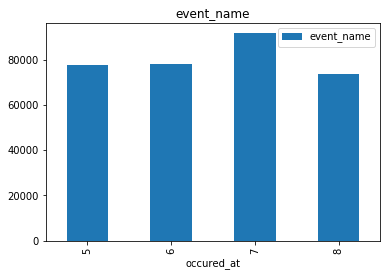

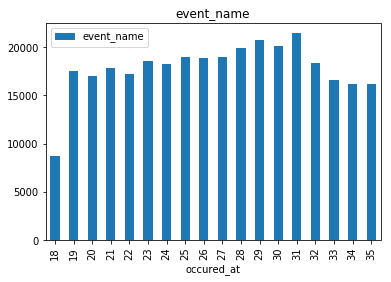

In [163]:
# Group events by week
events_data[['event_name']].groupby([events_data['occured_at'].dt.month]).count().plot.bar(subplots=True)
events_data[['event_name']].groupby([events_data['occured_at'].dt.week]).count().plot.bar(subplots=True)

From the bar chart, it is clear that there was also a drop in the number of events.

### Stratify engagement

#### By event_name

In [164]:
# Extract count of event names
conn = psycopg2.connect(dbname="yammer_data", user="postgres")

query = """
    SELECT CAST(EXTRACT(MONTH FROM occured_at) AS INT) AS Month, event_name, COUNT(event_name)
    FROM yammer_events
    WHERE event_type = 'engagement'
    GROUP BY Month, event_name
"""

event_name_data = pd.read_sql(query, conn)
conn.close()
print(event_name_data.sample(5))

    month             event_name  count
23      5  search_click_result_3    302
4       7  search_click_result_2    449
19      6              home_page  23014
59      8  search_click_result_1    274
8       5              home_page  22683


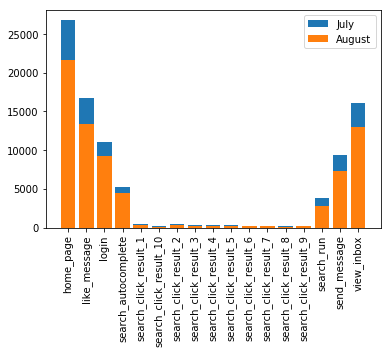

In [165]:
before_drop = event_name_data[event_name_data['month'] == 7].sort_values(by='event_name')
after_drop = event_name_data[event_name_data['month'] == 8].sort_values(by='event_name')
before_drop_plot = plt.bar(np.arange(len(before_drop['event_name'].unique())), before_drop['count'], label='July')
after_drop_plot = plt.bar(np.arange(len(after_drop['event_name'].unique())), after_drop['count'], label='August')
plt.xticks(np.arange(len(after_drop['event_name'].unique())), after_drop['event_name'].unique(), rotation=90)
plt.legend(handles=[before_drop_plot, after_drop_plot])

Based on the plot, it looks like all types of events had a drop in activity

#### By location

In [166]:
# Extract count of location
conn = psycopg2.connect(dbname="yammer_data", user="postgres")

query = """
    SELECT CAST(EXTRACT(MONTH FROM occured_at) AS INT) AS Month, location, COUNT(location)
    FROM yammer_events
    WHERE event_type = 'engagement'
    GROUP BY Month, location
"""

location_data = pd.read_sql(query, conn)
conn.close()
print(location_data.sample(5))

     month     location  count
160      5     Malaysia    640
171      7       Poland    767
67       8  Switzerland    668
137      5       Canada   2524
115      5         Iran    651


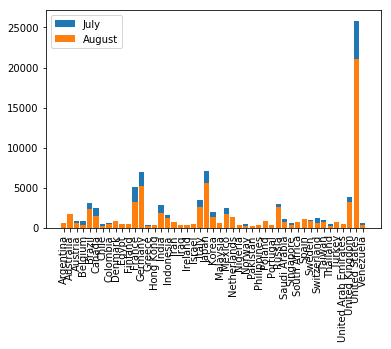

In [167]:
before_drop = location_data[location_data['month'] == 7].sort_values(by='location')
after_drop = location_data[location_data['month'] == 8].sort_values(by='location')
before_drop_plot = plt.bar(np.arange(len(before_drop['location'].unique())), before_drop['count'], label='July')
after_drop_plot = plt.bar(np.arange(len(after_drop['location'].unique())), after_drop['count'], label='August')
plt.xticks(np.arange(len(after_drop['location'].unique())), after_drop['location'].unique(), rotation=90)
plt.legend(handles=[before_drop_plot, after_drop_plot])

Based on the plot, it looks like countries with more activity has more dramatic drops

#### By Device

In [168]:
# Extract count of device
conn = psycopg2.connect(dbname="yammer_data", user="postgres")

query = """
    SELECT CAST(EXTRACT(MONTH FROM occured_at) AS INT) AS Month, device, COUNT(device)
    FROM yammer_events
    WHERE event_type = 'engagement'
    GROUP BY Month, device
"""

device_data = pd.read_sql(query, conn)
conn.close()
print(device_data.sample(5))

    month           device  count
96      5         mac mini   1026
76      5  asus chromebook   2053
72      5          htc one   1259
17      8  asus chromebook   2527
0       7  windows surface   1188


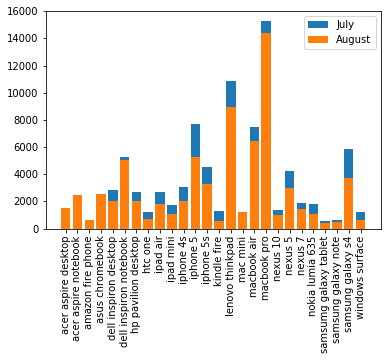

In [170]:
before_drop = device_data[device_data['month'] == 7].sort_values(by='device')
after_drop = device_data[device_data['month'] == 8].sort_values(by='device')
before_drop_plot = plt.bar(np.arange(len(before_drop['device'].unique())), before_drop['count'], label='July')
after_drop_plot = plt.bar(np.arange(len(after_drop['device'].unique())), after_drop['count'], label='August')
plt.xticks(np.arange(len(after_drop['device'].unique())), after_drop['device'].unique(), rotation=90)
plt.legend(handles=[before_drop_plot, after_drop_plot])

At a glance, it seems like mobile devices experiences sharper drops than computers. It would be worthwhile to perform statistical tests to confirm this.

### Test to see if there was a significant drop in engagement in mobile devices.

H_null: Mobile activity in August was not lower than in other months<br>
H_alternative: Mobile activity in August was lower than in other months

In [172]:
# Get list of devices
device_data['device'].unique()

array(['windows surface', 'hp pavilion desktop', 'nexus 7',
       'lenovo thinkpad', 'iphone 5s', 'acer aspire notebook',
       'amazon fire phone', 'samsung galaxy s4', 'iphone 5', 'kindle fire',
       'asus chromebook', 'acer aspire desktop', 'dell inspiron notebook',
       'ipad air', 'dell inspiron desktop', 'nexus 5', 'ipad mini',
       'nexus 10', 'iphone 4s', 'macbook pro', 'nokia lumia 635',
       'htc one', 'macbook air', 'samsumg galaxy tablet',
       'samsung galaxy note', 'mac mini'], dtype=object)

In [173]:
# create dictionary to map device to device type
device_types = {'windows surface': 'mobile',
               'hp pavilion desktop': 'computer',
               'nexus 7': 'mobile',
               'lenovo thinkpad': 'computer',
               'iphone 5s': 'mobile',
                'acer aspire notebook': 'computer',
                'amazon fire phone': 'mobile',
                'samsung galaxy s4': 'mobile',
                'iphone 5': 'mobile',
                'kindle fire': 'mobile',
                'asus chromebook': 'computer',
                'acer aspire desktop': 'computer',
                'dell inspiron notebook': 'computer',
                'ipad air': 'mobile',
                'dell inspiron desktop': 'computer',
                'nexus 5': 'mobile',
                'ipad mini': 'mobile',
                'nexus 10': 'mobile',
                'iphone 4s': 'mobile',
                'macbook pro': 'computer',
                'nokia lumia 635': 'mobile',
                'htc one': 'mobile',
                'macbook air': 'computer',
                'samsumg galaxy tablet': 'mobile',
                'samsung galaxy note': 'mobile',
                'mac mini': 'computer'}

device_data['device_type'] = device_data['device'].apply(lambda x: device_types[x])

In [198]:
before_drop_device_count = device_data.loc[device_data['month'] < 7 , ['device_type', 'count']].groupby(['device_type']).sum()
after_drop_device_count = device_data.loc[device_data['month'] == 8 , ['device_type', 'count']].groupby(['device_type']).sum()

In [207]:
counts = np.array([before_drop_device_count.loc['mobile'], after_drop_device_count.loc['mobile']])
nobs = np.array([before_drop_device_count.sum(), after_drop_device_count.sum()])

z_stat, p_value = proportion.proportions_ztest(counts, nobs, value=0, alternative='larger')
confidence_interval = proportion.proportion_confint(counts, nobs, alpha=0.05, method='normal')
before_drop_confidence_interval = np.array([confidence_interval[0][0], confidence_interval[1][0]])
after_drop_confidence_interval = np.array([confidence_interval[0][1], confidence_interval[1][1]])

print("The p-value from the z proportion test is", p_value)
print("Confidence interval before drop: " + str(before_drop_confidence_interval))
print("Confidence interval for after drop: " +  str(after_drop_confidence_interval))
print("Margin of error before drop is +/-", (before_drop_confidence_interval[1] - before_drop_confidence_interval[0])/len(before_drop_confidence_interval))
print("Margin of error after drop is +/-", (after_drop_confidence_interval[1] - after_drop_confidence_interval[0])/len(after_drop_confidence_interval))

The p-value from the z proportion test is [  1.60463742e-234]
Confidence interval before drop: [[ 0.43708216]
 [ 0.44200884]]
Confidence interval for after drop: [[ 0.36409004]
 [ 0.37104744]]
Margin of error before drop is +/- [ 0.00246334]
Margin of error after drop is +/- [ 0.0034787]


At a significance level of 0.01, we reject the null hypothesis and conclude that mobile activity was lower in August.

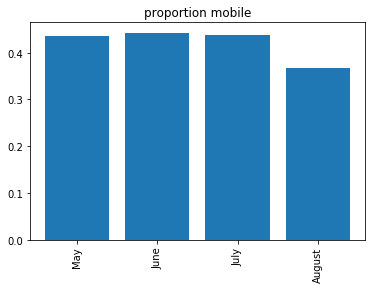

In [208]:
# Plot proportion of activity that is mobile for each month

may_drop_device_count = device_data.loc[device_data['month'] == 5 , ['device_type', 'count']].groupby(['device_type']).sum()
june_drop_device_count = device_data.loc[device_data['month'] == 6 , ['device_type', 'count']].groupby(['device_type']).sum()
july_drop_device_count = device_data.loc[device_data['month'] == 7 , ['device_type', 'count']].groupby(['device_type']).sum()
august_drop_device_count = device_data.loc[device_data['month'] == 8 , ['device_type', 'count']].groupby(['device_type']).sum()

proportions = np.array([
    may_drop_device_count.loc['mobile']/may_drop_device_count.sum(),
    june_drop_device_count.loc['mobile']/june_drop_device_count.sum(),
    july_drop_device_count.loc['mobile']/july_drop_device_count.sum(),
    august_drop_device_count.loc['mobile']/august_drop_device_count.sum()
])

plt.bar(np.arange(4),proportions)
plt.xticks(np.arange(4), ["May", "June", "July", "August"], rotation=90)
plt.title("proportion mobile")


Based on the above barplot, it is clear that there was a drop in mobile usage in August.

### Recommendation
Yammer should investigate user experience on mobile and determine whether changes made between July and August caused the drop in engagement.